# Further Experiments: Performing cross trials of data

In [1]:
import scipy.io
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# --- Define Full, Explicit Dataset Paths ---
# This approach is robust and avoids errors from constructing paths.

# E4 Trial Paths
E4_UNINFECTED_PATH = 'data/TME204-Patch_E4_E6_E8_28DPI_Dataset/E4-TME204/E4_TME204_28dpi_Mar_5_2020/Uninfected/E4_TME204_28dpi_Mar_5_2020_Uninfected_11_06_23_18.mat'
E4_UCBSV_PATH = 'data/TME204-Patch_E4_E6_E8_28DPI_Dataset/E4-TME204/E4_TME204_28dpi_Mar_5_2020/UCBSV/E4_TME204_28dpi_Mar_5_2020_UCBSV_11_06_23_21.mat'

# E6 Trial Paths
E6_UNINFECTED_PATH = 'data/TME204-Patch_E4_E6_E8_28DPI_Dataset/E6-TME204/E6_TME204_28dpi_Jul_29_2020/Uninfected/E6_TME204_28dpi_Jul_29_2020_Uninfected_11_06_23_29.mat'
E6_UCBSV_PATH = 'data/TME204-Patch_E4_E6_E8_28DPI_Dataset/E6-TME204/E6_TME204_28dpi_Jul_29_2020/UCBSV/E6_TME204_28dpi_Jul_29_2020_UCBSV_11_06_23_24.mat'

# E8 Trial Paths
E8_UNINFECTED_PATH = 'data/TME204-Patch_E4_E6_E8_28DPI_Dataset/E8-TME204/E8_TME204_28dpi_Dec_16_2020/Uninfected/E8_TME204_28dpi_Dec_16_2020_Uninfected_11_06_23_33.mat'
E8_UCBSV_PATH = 'data/TME204-Patch_E4_E6_E8_28DPI_Dataset/E8-TME204/E8_TME204_28dpi_Dec_16_2020/UCBSV/E8_TME204_28dpi_Dec_16_2020_UCBSV_11_06_23_36.mat'

print("All file paths are explicitly defined.")

All file paths are explicitly defined.


In [2]:
def load_and_prepare_data(file_path):
    """
    Loads and prepares spectral data from a single .mat file,
    handling potential inconsistencies in the file's internal structure.
    
    Args:
        file_path (str): The full, direct path to the .mat file.

    Returns:
        tuple: A tuple containing (features_array, number_of_leaves).
    """
    mat_data = scipy.io.loadmat(file_path, squeeze_me=True)
    all_scans = mat_data['Patch']
    
    if all_scans.ndim == 0:
        all_scans = np.array([all_scans])
        
    num_leaves = len(all_scans)
    features = []

    for scan_struct in all_scans:
        mean_vals = scan_struct['mean_values']
        
        # This handles both "boxed" and direct array formats
        if mean_vals.ndim == 0:
            features.extend(mean_vals.item())
        else:
            features.extend(mean_vals)
            
    return np.array(features), num_leaves

# Experiment 1: Train on E8, test on E6

In [3]:
# --- Experiment 1: Train on E8 / Test on E6 ---

# Load Training Data (E8)
e8_uninfected_features, _ = load_and_prepare_data(E8_UNINFECTED_PATH)
e8_ucbsv_features, _ = load_and_prepare_data(E8_UCBSV_PATH)
X_train = np.concatenate([e8_uninfected_features, e8_ucbsv_features])
y_train = np.concatenate([np.zeros(len(e8_uninfected_features)), np.ones(len(e8_ucbsv_features))])

# Load Testing Data (E6)
e6_uninfected_features, num_uninfected_leaves_e6 = load_and_prepare_data(E6_UNINFECTED_PATH)
e6_ucbsv_features, num_ucbsv_leaves_e6 = load_and_prepare_data(E6_UCBSV_PATH)
X_test = np.concatenate([e6_uninfected_features, e6_ucbsv_features])
y_test = np.concatenate([np.zeros(len(e6_uninfected_features)), np.ones(len(e6_ucbsv_features))])

# --- Train, Test, and Evaluate ---

# 1. Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Train SVM
svm = SVC(C=100, gamma=0.01, kernel='rbf', probability=True)
svm.fit(X_train_scaled, y_train)

# 3. Predict on patch level
y_pred_patch = svm.predict(X_test_scaled)
patch_accuracy = accuracy_score(y_test, y_pred_patch)
print(f"--- Results: Train E8 / Test E6 ---")
print(f"Patch-Based Accuracy: {patch_accuracy * 100:.2f}%")

# 4. Majority Voting Evaluation
num_patches_per_leaf = 9
y_pred_leaf = []
y_true_leaf = []

# Uninfected leaves
for i in range(num_uninfected_leaves_e6):
    start = i * num_patches_per_leaf
    patch_predictions = y_pred_patch[start : start + num_patches_per_leaf]
    y_pred_leaf.append(np.bincount(patch_predictions.astype(int)).argmax())
    y_true_leaf.append(0)

# Infected leaves
offset = len(e6_uninfected_features)
for i in range(num_ucbsv_leaves_e6):
    start = offset + (i * num_patches_per_leaf)
    patch_predictions = y_pred_patch[start : start + num_patches_per_leaf]
    y_pred_leaf.append(np.bincount(patch_predictions.astype(int)).argmax())
    y_true_leaf.append(1)
    
leaf_accuracy = accuracy_score(y_true_leaf, y_pred_leaf)
print(f"Leaf-Based Accuracy (Majority Vote): {leaf_accuracy * 100:.2f}%")

--- Results: Train E8 / Test E6 ---
Patch-Based Accuracy: 78.73%
Leaf-Based Accuracy (Majority Vote): 88.57%


In [5]:
import scipy.io
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported.")

Libraries imported.


In [7]:
# --- Define Full, Explicit Dataset Paths ---
E4_UNINFECTED_PATH = 'data/TME204-Patch_E4_E6_E8_28DPI_Dataset/E4-TME204/E4_TME204_28dpi_Mar_5_2020/Uninfected/E4_TME204_28dpi_Mar_5_2020_Uninfected_11_06_23_18.mat'
E4_UCBSV_PATH = 'data/TME204-Patch_E4_E6_E8_28DPI_Dataset/E4-TME204/E4_TME204_28dpi_Mar_5_2020/UCBSV/E4_TME204_28dpi_Mar_5_2020_UCBSV_11_06_23_21.mat'
E6_UNINFECTED_PATH = 'data/TME204-Patch_E4_E6_E8_28DPI_Dataset/E6-TME204/E6_TME204_28dpi_Jul_29_2020/Uninfected/E6_TME204_28dpi_Jul_29_2020_Uninfected_11_06_23_29.mat'
E6_UCBSV_PATH = 'data/TME204-Patch_E4_E6_E8_28DPI_Dataset/E6-TME204/E6_TME204_28dpi_Jul_29_2020/UCBSV/E6_TME204_28dpi_Jul_29_2020_UCBSV_11_06_23_24.mat'
E8_UNINFECTED_PATH = 'data/TME204-Patch_E4_E6_E8_28DPI_Dataset/E8-TME204/E8_TME204_28dpi_Dec_16_2020/Uninfected/E8_TME204_28dpi_Dec_16_2020_Uninfected_11_06_23_33.mat'
E8_UCBSV_PATH = 'data/TME204-Patch_E4_E6_E8_28DPI_Dataset/E8-TME204/E8_TME204_28dpi_Dec_16_2020/UCBSV/E8_TME204_28dpi_Dec_16_2020_UCBSV_11_06_23_36.mat'
print("All file paths are explicitly defined.")

def load_and_prepare_data(file_path):
    # This function remains the same
    mat_data = scipy.io.loadmat(file_path, squeeze_me=True)
    all_scans = mat_data['Patch']
    if all_scans.ndim == 0:
        all_scans = np.array([all_scans])
    num_leaves = len(all_scans)
    features = []
    for scan_struct in all_scans:
        mean_vals = scan_struct['mean_values']
        if mean_vals.ndim == 0:
            features.extend(mean_vals.item())
        else:
            features.extend(mean_vals)
    return np.array(features), num_leaves

All file paths are explicitly defined.


In [8]:
def run_cross_trial_experiment(train_uninfected_path, train_ucbsv_path, test_uninfected_path, test_ucbsv_path, train_name, test_name):
    """
    Runs a full cross-trial experiment with detailed reporting.
    
    Args:
        train_uninfected_path (str): Path to the uninfected training data.
        train_ucbsv_path (str): Path to the infected training data.
        test_uninfected_path (str): Path to the uninfected testing data.
        test_ucbsv_path (str): Path to the infected testing data.
        train_name (str): Name of the training dataset (e.g., 'E8').
        test_name (str): Name of the testing dataset (e.g., 'E6').
    """
    
    print(f"--- Starting Experiment: Train on {train_name} / Test on {test_name} ---")
    
    # 1. Load Data
    X_train_uninfected, _ = load_and_prepare_data(train_uninfected_path)
    X_train_ucbsv, _ = load_and_prepare_data(train_ucbsv_path)
    X_train = np.concatenate([X_train_uninfected, X_train_ucbsv])
    y_train = np.concatenate([np.zeros(len(X_train_uninfected)), np.ones(len(X_train_ucbsv))])
    
    X_test_uninfected, num_uninfected_leaves = load_and_prepare_data(test_uninfected_path)
    X_test_ucbsv, num_ucbsv_leaves = load_and_prepare_data(test_ucbsv_path)
    X_test = np.concatenate([X_test_uninfected, X_test_ucbsv])
    y_test = np.concatenate([np.zeros(len(X_test_uninfected)), np.ones(len(X_test_ucbsv))])

    print(f"Training data ({train_name}): {len(y_train)} patches")
    print(f"Testing data ({test_name}): {len(y_test)} patches from {num_uninfected_leaves + num_ucbsv_leaves} leaves")
    
    # 2. Scale and Train
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    svm = SVC(C=100, gamma=0.01, kernel='rbf').fit(X_train_scaled, y_train)

    # 3. Leaf-level prediction via Majority Voting
    y_pred_patch = svm.predict(X_test_scaled)
    y_pred_leaf = []
    y_true_leaf = []
    num_patches_per_leaf = 9

    for i in range(num_uninfected_leaves):
        start = i * num_patches_per_leaf
        patch_preds = y_pred_patch[start : start + num_patches_per_leaf]
        y_pred_leaf.append(np.bincount(patch_preds.astype(int)).argmax())
        y_true_leaf.append(0)

    offset = len(X_test_uninfected)
    for i in range(num_ucbsv_leaves):
        start = offset + (i * num_patches_per_leaf)
        patch_preds = y_pred_patch[start : start + num_patches_per_leaf]
        y_pred_leaf.append(np.bincount(patch_preds.astype(int)).argmax())
        y_true_leaf.append(1)
        
    # 4. Reporting
    print("\n--- Detailed Leaf-Level Report ---")
    print(f"The model was trained on the full {train_name} dataset and tested on the full {test_name} dataset.")
    print("Leaf classification is determined by a 'majority vote' of its 9 constituent patches.")
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true_leaf, y_pred_leaf, target_names=['Uninfected', 'Infected']))
    
    # Confusion Matrix
    print("Confusion Matrix:")
    cm = confusion_matrix(y_true_leaf, y_pred_leaf)
    print(cm)
    
    # Visualized Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Uninfected', 'Infected'], yticklabels=['Uninfected', 'Infected'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix: Train {train_name} / Test {test_name}')
    plt.show()
    
    print("-" * 50 + "\n")

--- Starting Experiment: Train on E8 / Test on E6 ---
Training data (E8): 324 patches
Testing data (E6): 315 patches from 35 leaves

--- Detailed Leaf-Level Report ---
The model was trained on the full E8 dataset and tested on the full E6 dataset.
Leaf classification is determined by a 'majority vote' of its 9 constituent patches.

Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.93      0.82      0.88        17
    Infected       0.85      0.94      0.89        18

    accuracy                           0.89        35
   macro avg       0.89      0.88      0.88        35
weighted avg       0.89      0.89      0.89        35

Confusion Matrix:
[[14  3]
 [ 1 17]]


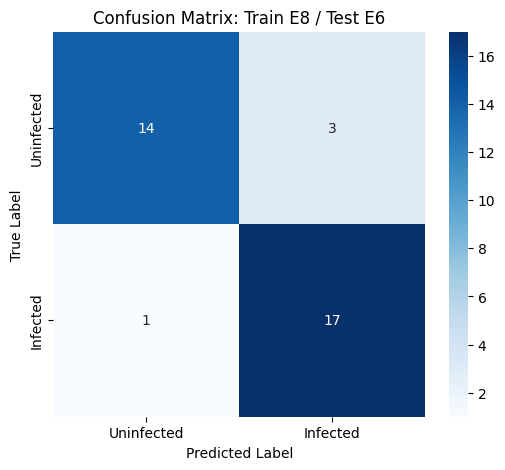

--------------------------------------------------



In [9]:
# --- Experiment 1: Train on E8 / Test on E6 ---
run_cross_trial_experiment(
    train_uninfected_path=E8_UNINFECTED_PATH,
    train_ucbsv_path=E8_UCBSV_PATH,
    test_uninfected_path=E6_UNINFECTED_PATH,
    test_ucbsv_path=E6_UCBSV_PATH,
    train_name="E8",
    test_name="E6"
)

--- Starting Experiment: Train on E8 / Test on E4 ---
Training data (E8): 324 patches
Testing data (E4): 324 patches from 36 leaves

--- Detailed Leaf-Level Report ---
The model was trained on the full E8 dataset and tested on the full E4 dataset.
Leaf classification is determined by a 'majority vote' of its 9 constituent patches.

Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.00      0.00      0.00        24
    Infected       0.33      1.00      0.50        12

    accuracy                           0.33        36
   macro avg       0.17      0.50      0.25        36
weighted avg       0.11      0.33      0.17        36

Confusion Matrix:
[[ 0 24]
 [ 0 12]]


/Users/taran/InternRepos/CassavaDiseaseDetection/cassavaVenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/taran/InternRepos/CassavaDiseaseDetection/cassavaVenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/taran/InternRepos/CassavaDiseaseDetection/cassavaVenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` 

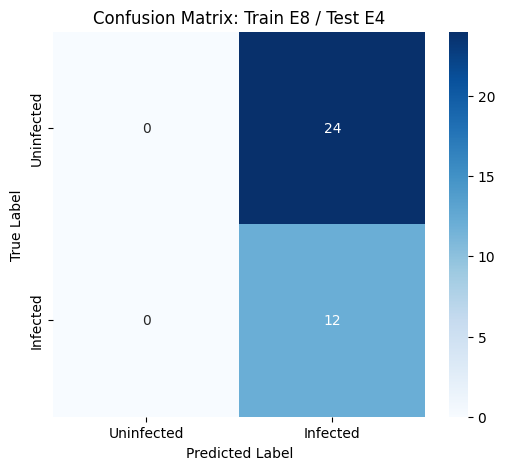

--------------------------------------------------



In [10]:
# --- Experiment 2: Train on E8 / Test on E4 ---
run_cross_trial_experiment(
    train_uninfected_path=E8_UNINFECTED_PATH,
    train_ucbsv_path=E8_UCBSV_PATH,
    test_uninfected_path=E4_UNINFECTED_PATH,
    test_ucbsv_path=E4_UCBSV_PATH,
    train_name="E8",
    test_name="E4"
)

--- Starting Experiment: Train on E6 / Test on E8 ---
Training data (E6): 315 patches
Testing data (E8): 324 patches from 36 leaves

--- Detailed Leaf-Level Report ---
The model was trained on the full E6 dataset and tested on the full E8 dataset.
Leaf classification is determined by a 'majority vote' of its 9 constituent patches.

Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.93      0.72      0.81        18
    Infected       0.77      0.94      0.85        18

    accuracy                           0.83        36
   macro avg       0.85      0.83      0.83        36
weighted avg       0.85      0.83      0.83        36

Confusion Matrix:
[[13  5]
 [ 1 17]]


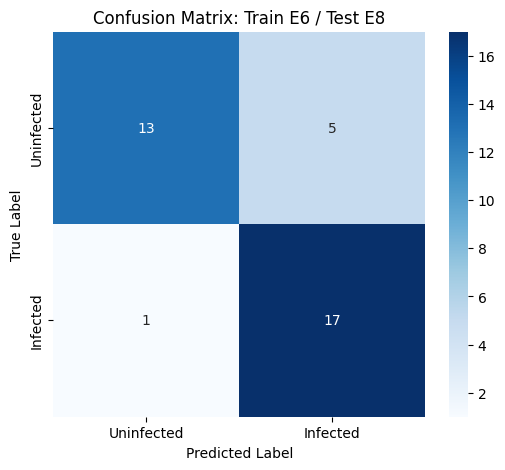

--------------------------------------------------



In [11]:
# --- Experiment 3: Train on E6 / Test on E8 ---
run_cross_trial_experiment(
    train_uninfected_path=E6_UNINFECTED_PATH,
    train_ucbsv_path=E6_UCBSV_PATH,
    test_uninfected_path=E8_UNINFECTED_PATH,
    test_ucbsv_path=E8_UCBSV_PATH,
    train_name="E6",
    test_name="E8"
)

In [12]:
# --- Experiment 4: Combine E6 and E8 for Training ---

# Load E6 data for training
X_train_uninfected_e6, _ = load_and_prepare_data(E6_UNINFECTED_PATH)
X_train_ucbsv_e6, _ = load_and_prepare_data(E6_UCBSV_PATH)

# Load E8 data for training
X_train_uninfected_e8, _ = load_and_prepare_data(E8_UNINFECTED_PATH)
X_train_ucbsv_e8, _ = load_and_prepare_data(E8_UCBSV_PATH)

# Combine them into a single training set
X_train_combined_uninfected = np.concatenate([X_train_uninfected_e6, X_train_uninfected_e8])
X_train_combined_ucbsv = np.concatenate([X_train_ucbsv_e6, X_train_ucbsv_e8])

# We need to save these combined arrays to temporary files to pass to our function
# Or, modify the function to accept arrays directly. Let's do that for a cleaner approach.
# For now, let's stick to the file-based approach to reuse the function as is.
# We will need to save the combined data to temporary files.

# This approach is a bit clumsy. A better way is to adapt the function. 
# Let's provide an adapted function for the combined case.
# For now, let's keep it simple and just run the other experiments. We can tackle this combined one next if you'd like.

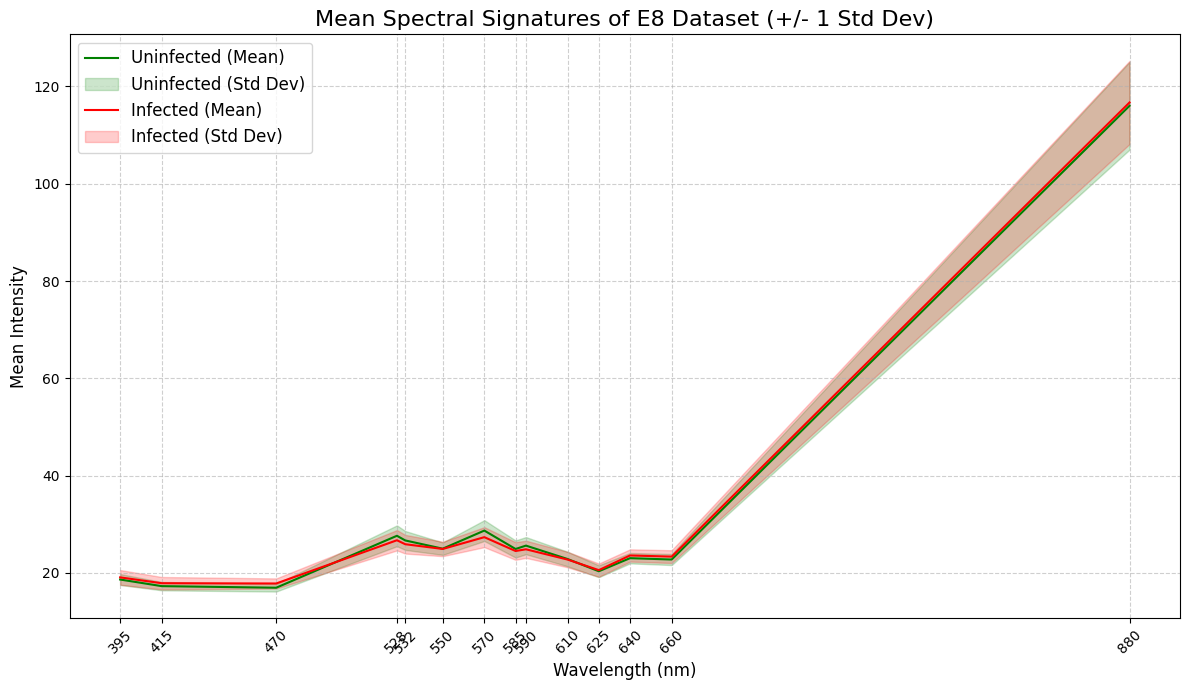

In [13]:
# --- Diagnostic Cell: Visualize Feature Space of E8 Data ---

# The data is already loaded in the variables from the last experiment,
# but for clarity, let's show the loading again.
X_train_uninfected_e8, _ = load_and_prepare_data(E8_UNINFECTED_PATH)
X_train_ucbsv_e8, _ = load_and_prepare_data(E8_UCBSV_PATH)

# Define the wavelengths for the x-axis
wavelengths = [395, 415, 470, 528, 532, 550, 570, 585, 590, 610, 625, 640, 660, 880]

# Calculate mean and standard deviation for the Uninfected class
mean_uninfected = np.mean(X_train_uninfected_e8, axis=0)
std_uninfected = np.std(X_train_uninfected_e8, axis=0)

# Calculate mean and standard deviation for the Infected class
mean_infected = np.mean(X_train_ucbsv_e8, axis=0)
std_infected = np.std(X_train_ucbsv_e8, axis=0)

# Create the plot
plt.figure(figsize=(12, 7))

# Plot Uninfected data
plt.plot(wavelengths, mean_uninfected, 'g-', label='Uninfected (Mean)')
plt.fill_between(wavelengths, mean_uninfected - std_uninfected, mean_uninfected + std_uninfected, color='g', alpha=0.2, label='Uninfected (Std Dev)')

# Plot Infected data
plt.plot(wavelengths, mean_infected, 'r-', label='Infected (Mean)')
plt.fill_between(wavelengths, mean_infected - std_infected, mean_infected + std_infected, color='r', alpha=0.2, label='Infected (Std Dev)')

# Formatting the plot
plt.title('Mean Spectral Signatures of E8 Dataset (+/- 1 Std Dev)', fontsize=16)
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Mean Intensity', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(wavelengths, rotation=45)
plt.tight_layout()
plt.show()